In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import discretize
from discretize import TensorMesh
    
import SimPEG.electromagnetics.frequency_domain as fdem
from SimPEG.utils import mkvc, plot_1d_layer_model

from SimPEG import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

import sys
sys.path.append("../")
from inversion_toolkit.model_functions import get_1d_model, generate_survey
from inversion_toolkit.inversion_functions import define_inverse_problem_1DLayered

## Load Data and Plot

In [2]:
# path to the directory containing our data
dir_path = "./3d_simulation_data/"
data_filename = dir_path + "em3dfm_1d_data_1DLayered.txt"

In [3]:
imported_1d_data = np.loadtxt(str(data_filename), skiprows=1)
ntx = int((imported_1d_data.shape[1]-1)/2)

# Define receiver locations and observed data
frequencies = imported_1d_data[:, 0]

In [4]:
x_positions = np.arange(0, 10000, 500)

## Starting with One Sounding Point

Skip to Complete Inversion Section if you don't want to test the inversion at one sounding point

In [11]:
def get_dobs_from_1d_data(imported_1d_data, location_index):
    dobs_real = imported_1d_data[:, 1::2].T
    dobs_imag = imported_1d_data[:, 2::2].T
    bz_real = dobs_real[location_index]
    bz_imag = dobs_imag[location_index]

    dobs = np.empty(bz_real.size + bz_imag.size, dtype=bz_real.dtype)
    dobs[0::2] = bz_real
    dobs[1::2] = bz_imag
    return dobs

In [ ]:
location_index = 0

dobs = get_dobs_from_1d_data(imported_1d_data, location_index)

# Plot FEM response for all frequencies
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.semilogx(frequencies, (10**9)*dobs[0::2], "r-o", lw=3)
ax.semilogx(frequencies, (10**9)*dobs[1::2], "b:o", lw=3)
ax.set_xlim((np.min(frequencies), np.max(frequencies)))
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Bz secondary [nT]")
ax.set_title("Magnetic Field Data")
ax.legend(["Real", "Imaginary"])
plt.show()

### Defining the Survey

In [ ]:
survey = generate_survey(frequencies=frequencies, x_position=x_positions[location_index], moment=1)

### Assign Uncertainties

In [ ]:
uncertainties = 0.01 * np.abs(dobs) * np.ones(np.shape(dobs))
data_object = data.Data(survey, dobs=dobs, noise_floor=uncertainties)

### Weighted Least-Squares Inversion

In [5]:
# estimated host conductivity (S/m)
estimated_resistivity = 100

# minimum skin depth
d_min = 500.0 * np.sqrt(estimated_resistivity/ frequencies.max())
print("MINIMUM SKIN DEPTH: {} m".format(d_min))

# maximum skin depth
d_max = 500.0 * np.sqrt(estimated_resistivity/ frequencies.min())
print("MAXIMUM SKIN DEPTH: {} m".format(d_max))

MINIMUM SKIN DEPTH: 5.0 m
MAXIMUM SKIN DEPTH: 500000.0 m


In [6]:
depth_min = 5  # top layer thickness
depth_max = 5000.0  # depth to lowest layer
geometric_factor = 1.1  # rate of thickness increase

In [7]:
# Increase subsequent layer thicknesses by the geometric factors until
# it reaches the maximum layer depth.
layer_thicknesses = [depth_min]
while np.sum(layer_thicknesses) < depth_max:
    layer_thicknesses.append(geometric_factor * layer_thicknesses[-1])

n_layers = len(layer_thicknesses) + 1  # Number of layers
print("n_layers: ", n_layers)

n_layers:  50


### Model and Mapping to Layer Conductivities

In [8]:
log_resistivity_map = maps.ExpMap(nP=n_layers)

### Define a Refernce Model and the Mapping

In [9]:
# Starting model is log-conductivity values (S/m)
starting_resistivity_model = np.log((estimated_resistivity) * np.ones(n_layers))

# Reference model is also log-resistivity values (S/m)
reference_resistivity_model = starting_resistivity_model.copy()

In [ ]:
simulation_L2 = fdem.Simulation1DLayered(
    survey=survey, thicknesses=layer_thicknesses, rhoMap=log_resistivity_map
)

### Define Inverse Problem

The inverse problem is defined by 3 things:

    1) Data Misfit: a measure of how well our recovered model explains the field data
    2) Regularization: constraints placed on the recovered model and a priori information
    3) Optimization: the numerical approach used to solve the inverse problem

In [ ]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# The weighting is defined by the reciprocal of the uncertainties.
dmis_L2 = data_misfit.L2DataMisfit(simulation=simulation_L2, data=data_object)

In [13]:
# Define 1D cell widths
h = np.r_[layer_thicknesses, layer_thicknesses[-1]]
h = np.flipud(h)

# Create regularization mesh
regularization_mesh = TensorMesh([h], "N")
print(regularization_mesh)


  TensorMesh: 50 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     50     -5,771.03          0.00      5.00    485.09    1.10




In [ ]:
reg_L2 = regularization.WeightedLeastSquares(
    regularization_mesh,
    length_scale_x=10.0,
    reference_model=reference_resistivity_model,
    reference_model_in_smooth=False,
)

In [ ]:
opt_L2 = optimization.InexactGaussNewton(
    maxIter=100, maxIterLS=20, maxIterCG=20, tolCG=1e-3
)

### Define Inversion Directives

In [ ]:
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

In [ ]:
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=5)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=3)
target_misfit = directives.TargetMisfit(chifact=1.0)

directives_list_L2 = [update_jacobi, 
                      starting_beta, 
                      beta_schedule, 
                      target_misfit]

In [ ]:
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run the inversion
recovered_model_L2 = inv_L2.run(starting_resistivity_model)

In [ ]:
dpred_L2 = simulation_L2.dpred(recovered_model_L2)

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = [fig.add_axes([0.1 + ii * 0.5, 0.1, 0.37, 0.85]) for ii in range(2)]
for ii in range(2):
    ax[ii].semilogx(frequencies, (10**9) *(dobs[ii::2]), "k-o", lw=2)
    ax[ii].semilogx(frequencies, (10**9) *(dpred_L2[ii::2]), "b-o", lw=2)
    ax[ii].grid(which="both")
    ax[ii].set_xlabel("Frequency (Hz)")
    ax[ii].set_ylabel("Bz Seconds [nT]")
    ax[ii].legend(["Observed", "L2 Inversion"])
    if ii == 1:
        ax[ii].set_ylabel("")

ax[0].set_title("Real Component")
ax[1].set_title("Imaginary Component")
plt.show()

In [ ]:
m_true = np.load("../models/2d-model-array.npy")
inversion_mesh_2d = discretize.load_mesh("../meshes/inversion_mesh_2d.json")
true_layers,true_log_resistivity_map, true_log_resistivities,_ = get_1d_model(x_positions[location_index],
                                                                              m_true, 
                                                                              inversion_mesh_2d
                                                                              )
true_resistivities = true_log_resistivity_map*true_log_resistivities

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6, 6))

plot_1d_layer_model(true_layers, true_resistivities, ax=ax, color="k")
plot_1d_layer_model(layer_thicknesses, log_resistivity_map * recovered_model_L2, ax=ax, color="b")
ax.grid(which="both")
ax.set_xlabel(r"Resistivity ($\Omega m$)")
x_min, x_max = true_resistivities.min(), true_resistivities.max()
ax.set_ylim([4000, 0])
ax.set_xlim(0.5 * x_min, 1.5 * x_max)
ax.legend(["True Model", "L2-Model"])
plt.show()

## Complete Inversion by Interpolation

In [14]:
models = []
for i, x in enumerate(x_positions):
    survey = generate_survey(frequencies=frequencies, x_position=x, moment=1)
    dobs = get_dobs_from_1d_data(imported_1d_data, location_index=i)
    uncertainties = 0.01 * np.abs(dobs) * np.ones(np.shape(dobs))
    data_object = data.Data(survey, dobs=dobs, noise_floor=uncertainties)
    simulation_L2 = fdem.Simulation1DLayered(
    survey=survey, thicknesses=layer_thicknesses, rhoMap=log_resistivity_map
    )
    inv_L2 = define_inverse_problem_1DLayered(simulation_L2, data_object, regularization_mesh, reference_resistivity_model)
    recovered_model_L2 = inv_L2.run(starting_resistivity_model)
    models.append(recovered_model_L2)
    


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.14e+03  5.61e+06  0.00e+00  5.61e+06    3.56e+06      0              
   1  4.14e+03  2.42e+06  3.26e+02  3.77e+06    5.67e+05      0              
   2  4.14e+03  2.78e+06  2.22e+02  3.70e+06    1.74e+05      0              
   3  2.07e+03  2.67e+06  2.47e+02  3.18e+06    8.27e+05      0              
   4  2.07e+03  1.76e+06  5.95e+02  2.99e+06    2.28e+05      0              
   5  2.07e+03  1.98e+06  4.81e+02  2.98e+06    9.35e+04      0              
   6  1.03e+03  1.90e+06  5.20e+0

### Plot in 2D by Porjecting 1D data onto 2D mesh

In [15]:
# Define cell widths in x-direction
cell_width = np.diff(x_positions)[0]
hx = [cell_width]
hz = -np.array(layer_thicknesses)

# Create TensorMesh
plotting_mesh = discretize.TensorMesh([hx, hz])
plotting_mesh.x0 = [0, 0]

(-4000.0, 0.0)

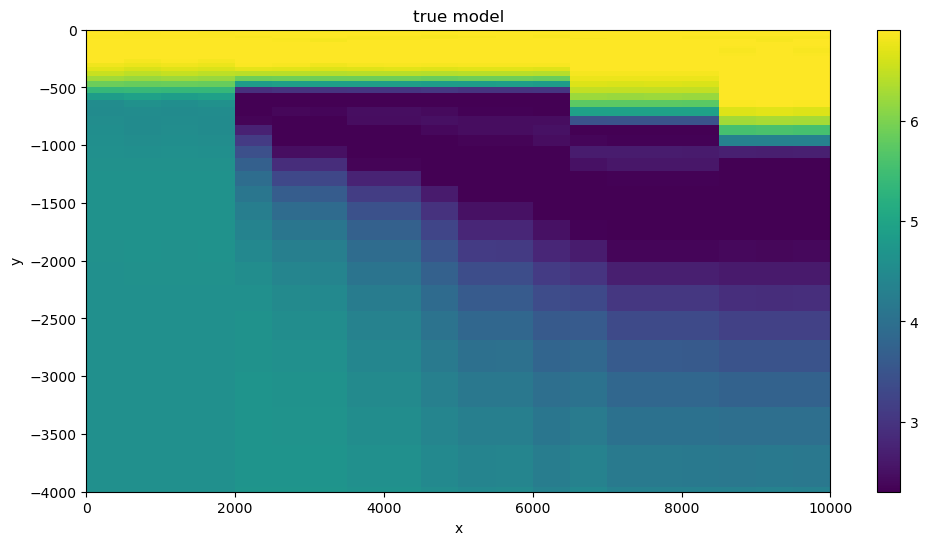

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
clim = np.r_[np.log(10), np.log(1000)]
images = []
for i, x in enumerate(x_positions):
    plotting_mesh.x0 = [x, 0]
    model = models[i]
    image = plotting_mesh.plot_image(model[:-1], ax=ax, clim=clim)[0]
    images.append(image)

cb = plt.colorbar(images[-1], ax=ax)
ax.set_title("true model")
ax.set_xlim([0, 10.0e3])
ax.set_ylim([-4.0e3, 0])

## Interpolate in between

In [17]:
# Define cell widths in x-direction
cell_width = np.diff(x_positions)[0]
hx = [cell_width/4]
hz = -np.array(layer_thicknesses)

# Create TensorMesh
plotting_mesh_quarter = discretize.TensorMesh([hx, hz])
plotting_mesh_quarter.x0 = [0, 0]

(-4000.0, 0.0)

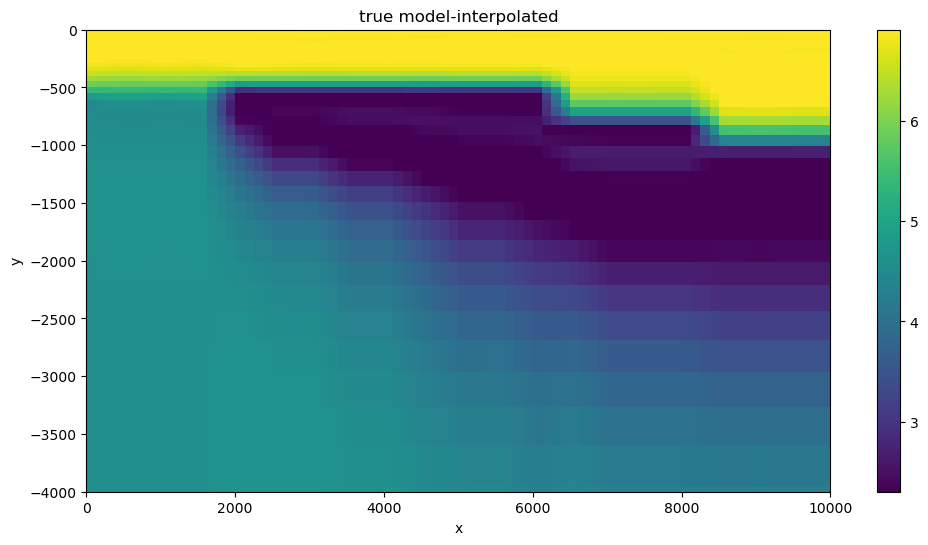

In [43]:
# Initialize an empty array to store interpolated models
interpolated_models = []

# Interpolate between each model
for i in range(len(models) - 1):
    # Get the current and next model
    current_model = models[i]
    next_model = models[i + 1]

    # Interpolate between the current and next models along the x-direction
    interpolated_model = np.linspace(current_model, next_model, num=5, axis=1)
    # Append the interpolated model to the list
    interpolated_models.append(interpolated_model)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
clim = np.r_[np.log(10), np.log(1000)]
pos_1 = 0
for i in range(len(interpolated_models)):
    new_model = interpolated_models[i]
    plotting_mesh_quarter.x0 = [pos_1, 0]
    plotting_mesh_quarter.plot_image(new_model[:,0][:-1], ax=ax, clim=clim)[0]
    plotting_mesh_quarter.x0 = [pos_1+125, 0]
    plotting_mesh_quarter.plot_image(new_model[:,1][:-1], ax=ax, clim=clim)[0]
    plotting_mesh_quarter.x0 = [pos_1+250, 0]
    plotting_mesh_quarter.plot_image(new_model[:,2][:-1], ax=ax, clim=clim)[0]
    plotting_mesh_quarter.x0 = [pos_1+375, 0]
    plotting_mesh_quarter.plot_image(new_model[:,3][:-1], ax=ax, clim=clim)[0]
    if i == len(interpolated_models) - 1:
        plotting_mesh_quarter.x0 = [pos_1+500, 0]
        plotting_mesh_quarter.plot_image(new_model[:,4][:-1], ax=ax, clim=clim)[0]
        plotting_mesh.x0 = [pos_1+625, 0]
        image = plotting_mesh.plot_image(models[-1][:-1], ax=ax, clim=clim)[0]
    pos_1 += 500

cb = plt.colorbar(image, ax=ax)
ax.set_title("true model-interpolated")
ax.set_xlim([0, 10.0e3])
ax.set_ylim([-4.0e3, 0])